In [1]:
import ionchain
import classes
import pickle
import numpy as np
import network
import network2
% matplotlib inline

In [2]:
def Lamb_Dicke(ic):
    """Computes Lamb-Dicke parameters for a trapped ion chain 
    
    Args:
        ic (Object) - an instance of a trapped ion chain
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,mth entry of the matrix corresponds to the Lambe-Dicke
        parameter eta[i,m] which sets the scale for the coupling between
        spin i and mode m.
    """
    deltak = 2*1.7699*10**7
    M = 2.8395 * 10**(-25)
    hbar = 1.0546e-34
    n = ic.n
    b_ij = ic.x_eigvecs
    omega_m = ic.x_freqs
    eta = np.empty([n,n])
    for m in range(n):
        for i in range(n):
            eta[i,m] = b_ij[i,m]*deltak*((hbar/(2*M*omega_m[m]))**0.5)
    return eta

In [3]:
def J_ij1(mu, Rabi_freq, ic):
    """Computes spin-spin coupling beteen atoms in a trapped ion
    chain with global beatnote detuning. 
    
    Args:
        mu(float) - global beatnote detuning parameter
        ic (Object) - an instance of a trapped ion chain
        Rabi_freq(An 1Xn vector of floats, where n is number of ions
        in the chain) 
            - containing where the ith entry is the single spin Rabi
            frequency of atom i
        
    Returns:
        An nxn matrix where n is the number of ions in the ion chain.
        The i,jth is the spin-spin coupling beteen atoms i and j in the
        ion chain.
    """
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    J = np.empty((n,n))
    for i in range(n):
        J[i,i] = 0
        for j in range(i+1,n):
            J[i,j] = Rabi_freq[i]*Rabi_freq[j]* np.sum(eta[i, :] * eta[j, :] * omega_m[:] /(np.full((1,n),mu)**2 - omega_m[:]**2))
    return J

In [4]:
def J_ij(mus, Rabi_freq_matrix,ic):
    n = ic.n
    eta = Lamb_Dicke(ic)
    omega_m = ic.x_freqs
    F = np.empty((n, n, len(mus)))
    for i in range(n):
        for j in range(n):
            for m in range(len(mus)):
                F[i, j, m] = np.sum(eta[i, :] * eta[j, :] * omega_m[:] /
                                    (mus[m]**2 - omega_m[:]**2))
    J = np.empty((n, n))
    for i in range(n):
        J[i, i] = 0
        for j in range(i + 1, n):
            J[i, j] = np.sum(Rabi_freq_matrix[i, :] * Rabi_freq_matrix[j, :] * F[i, j, :])
            J[j, i] = J[i, j]
    return J

In [5]:
def test_data(ic, data_size):
    """Generates training, test and validation data for a 
    particular ion chain ic. The function returns 3 tuples corresponding 
    to each data set. Each tuple contains 2 items. The first is the J_ij
    values for the system in vectorized form(by row). If n is the size of
    the ion chain, the second contains a vector whose first n entires
    are the parameters mu and the remaining entires are the vectorized
    form of the Rabi frequency matrix"""
    n = ic.n
    np.random.seed(123)
    
    # Generate random values for the Rabi matricies and detunings(the first mu_size values correspond
    #to mu and the rest to the Rabi frequencies.
    # The size of the ion chain will determine the number of output values in the network.
    data = []
    for i in range (0, data_size):
        mu = np.random.uniform(low=0, high=1, size=(n,1))
        Rabi = np.random.uniform(low=0, high=1, size=(n,n))     
    # For each set of parameters y we generate corresponding Ising coupling matrix J which
    # will be our input parameters for the neural network
        J = J_ij(mu, Rabi, ic)
        x = np.reshape(J,(n**2,1))
        y = np.concatenate((mu, np.reshape(Rabi,(n**2,1))), axis=0)
        data.append((x,y))
        
    # Split up the data into training/test/validation sets.
    train_set = data[:int(len(x)*0.6)]
    test_set = data[int(len(x)*0.6):int(len(x)*0.8)]
    valid_set = data[int(len(x)*0.8):]    
    
    # Return the dataset in pairs of x,y for train/test/validation sets.
    return data

def create_data_file(filename, ic, data_size):
    data = test_data(ic, data_size)
    f = open(filename, 'wb')
    pickle.dump(data, f)
    f.close()
    

# Notes on Network Performance
Currently the parameters $\mu$ and $\Omega$ are taken from a uniform distribution. The output activations will also lie in the (0,1) interval. The expected distance between two values drawn from a uniform [0,1] distribution is $\frac{1}{3}$. Since we have $n^2+n$ parameters for an ion chain of size n, we get that if the network is outputting just a guess that the cost should be approximately $\frac{n^2+n}{6}$.

One thing we should consider is whether or not the parameters do indeed lie in this interval. And if so what is an appropriate level of error that will give enough guidance. Is there another network we can train given a better estimate of parameters.



In [6]:
ionchain3 = ionchain.IonChain(3,[5,1])
#create_data_file('chain_len3.pickle',ionchain3,100000)

In [7]:
# net = network.Network([9,100,12])
# ionchain3 = ionchain.IonChain(3,[5,1])
# data = test_data(ionchain3,80000)
# train_data = data[:int(len(data)*0.8)]
# test_data = data[int(len(data)*0.8):] 
# net.SGD(train_data, 30, 10, 3, test_data)

Epoch 0 training complete
Cost on training data: 0.7993148086658534
Cost on evaluation data: 0.795092999275833
Epoch 1 training complete
Cost on training data: 0.7297966424954095
Cost on evaluation data: 0.7294172515901276
Epoch 2 training complete
Cost on training data: 0.6679551916408132
Cost on evaluation data: 0.6709525249709308
Epoch 3 training complete
Cost on training data: 0.615350179138068
Cost on evaluation data: 0.6213508966861797
Epoch 4 training complete
Cost on training data: 0.5739357301977653
Cost on evaluation data: 0.5828977654557536
Epoch 5 training complete
Cost on training data: 0.5442674364116861
Cost on evaluation data: 0.5547227132139761
Epoch 6 training complete
Cost on training data: 0.5242410026223497
Cost on evaluation data: 0.5354907935113159
Epoch 7 training complete
Cost on training data: 0.5115691676466783
Cost on evaluation data: 0.5235012628350013
Epoch 8 training complete
Cost on training data: 0.5039477302764144
Cost on evaluation data: 0.51663979049

Epoch 73 training complete
Cost on training data: 0.469251792613657
Cost on evaluation data: 0.48609864882364306
Epoch 74 training complete
Cost on training data: 0.46916031271228764
Cost on evaluation data: 0.48574955126377195
Epoch 75 training complete
Cost on training data: 0.4688646472070212
Cost on evaluation data: 0.48576078580701587
Epoch 76 training complete
Cost on training data: 0.46860500291632323
Cost on evaluation data: 0.48552731707748165
Epoch 77 training complete
Cost on training data: 0.4684253980027157
Cost on evaluation data: 0.48541050716470224
Epoch 78 training complete
Cost on training data: 0.4682373132587542
Cost on evaluation data: 0.4851932079440099
Epoch 79 training complete
Cost on training data: 0.46806188661771436
Cost on evaluation data: 0.4849677533160571
Epoch 80 training complete
Cost on training data: 0.4679173994690097
Cost on evaluation data: 0.48481653373120187
Epoch 81 training complete
Cost on training data: 0.46771374488769735
Cost on evaluation

Epoch 145 training complete
Cost on training data: 0.45925533468147967
Cost on evaluation data: 0.47694349712578255
Epoch 146 training complete
Cost on training data: 0.4590443280015455
Cost on evaluation data: 0.4767836917658868
Epoch 147 training complete
Cost on training data: 0.4589399624887495
Cost on evaluation data: 0.4766230699816641
Epoch 148 training complete
Cost on training data: 0.4592129401153855
Cost on evaluation data: 0.4768476120697825
Epoch 149 training complete
Cost on training data: 0.4587613036961266
Cost on evaluation data: 0.47653083145153624
Epoch 150 training complete
Cost on training data: 0.45864754131874
Cost on evaluation data: 0.4763785159220642
Epoch 151 training complete
Cost on training data: 0.4589170708696194
Cost on evaluation data: 0.47668156608272294
Epoch 152 training complete
Cost on training data: 0.45848771122887205
Cost on evaluation data: 0.47632741058110467
Epoch 153 training complete
Cost on training data: 0.4583712333269773
Cost on evalua

Epoch 217 training complete
Cost on training data: 0.45004441251896293
Cost on evaluation data: 0.4700833555806024
Epoch 218 training complete
Cost on training data: 0.44993631903150383
Cost on evaluation data: 0.470457719725593
Epoch 219 training complete
Cost on training data: 0.44995210120198625
Cost on evaluation data: 0.47099104655811364
Epoch 220 training complete
Cost on training data: 0.450045742360575
Cost on evaluation data: 0.46934396782452437
Epoch 221 training complete
Cost on training data: 0.4497643415695058
Cost on evaluation data: 0.4707859588257453
Epoch 222 training complete
Cost on training data: 0.44958742939931984
Cost on evaluation data: 0.4703727114904772
Epoch 223 training complete
Cost on training data: 0.4494804620261667
Cost on evaluation data: 0.4699801260744838
Epoch 224 training complete
Cost on training data: 0.4494092585139628
Cost on evaluation data: 0.4698990429379965
Epoch 225 training complete
Cost on training data: 0.44930858834097614
Cost on evalu

Epoch 289 training complete
Cost on training data: 0.44286398619725875
Cost on evaluation data: 0.4648798704378289
Epoch 290 training complete
Cost on training data: 0.4426756742815586
Cost on evaluation data: 0.4648372099036986
Epoch 291 training complete
Cost on training data: 0.44258889691894987
Cost on evaluation data: 0.4646184792990216
Epoch 292 training complete
Cost on training data: 0.4425866782717279
Cost on evaluation data: 0.4641777968414583
Epoch 293 training complete
Cost on training data: 0.4427396776213761
Cost on evaluation data: 0.46571162354169393
Epoch 294 training complete
Cost on training data: 0.4425790082772925
Cost on evaluation data: 0.46529977812685464
Epoch 295 training complete
Cost on training data: 0.44237578988325615
Cost on evaluation data: 0.464215692146429
Epoch 296 training complete
Cost on training data: 0.4423174758583718
Cost on evaluation data: 0.4645016283225975
Epoch 297 training complete
Cost on training data: 0.44222988818925485
Cost on evalu

Epoch 361 training complete
Cost on training data: 0.43862436762689117
Cost on evaluation data: 0.4617736968715008
Epoch 362 training complete
Cost on training data: 0.4388042335790553
Cost on evaluation data: 0.46159953505466816
Epoch 363 training complete
Cost on training data: 0.4389644973241811
Cost on evaluation data: 0.46287608817664044
Epoch 364 training complete
Cost on training data: 0.4385715058482995
Cost on evaluation data: 0.4623328606909835
Epoch 365 training complete
Cost on training data: 0.43856610789278994
Cost on evaluation data: 0.46242267664980347
Epoch 366 training complete
Cost on training data: 0.4386088818397194
Cost on evaluation data: 0.4612015644183152
Epoch 367 training complete
Cost on training data: 0.43867892653143975
Cost on evaluation data: 0.46285241325771725
Epoch 368 training complete
Cost on training data: 0.43855948136737016
Cost on evaluation data: 0.4624434324415738
Epoch 369 training complete
Cost on training data: 0.4382765461082012
Cost on ev

Epoch 433 training complete
Cost on training data: 0.4355299330486117
Cost on evaluation data: 0.4599737708918072
Epoch 434 training complete
Cost on training data: 0.43518477290456115
Cost on evaluation data: 0.4596070911555947
Epoch 435 training complete
Cost on training data: 0.4353006596066511
Cost on evaluation data: 0.4603849402635415
Epoch 436 training complete
Cost on training data: 0.43519146418967636
Cost on evaluation data: 0.4602981074200022
Epoch 437 training complete
Cost on training data: 0.4350377147637489
Cost on evaluation data: 0.4598401109807846
Epoch 438 training complete
Cost on training data: 0.43525747614078697
Cost on evaluation data: 0.4603871909779577
Epoch 439 training complete
Cost on training data: 0.43501992967004266
Cost on evaluation data: 0.45946024697763593
Epoch 440 training complete
Cost on training data: 0.43517255818700407
Cost on evaluation data: 0.46065115691905983
Epoch 441 training complete
Cost on training data: 0.43521734798280487
Cost on ev

Epoch 505 training complete
Cost on training data: 0.4327617410996153
Cost on evaluation data: 0.4582880198900249
Epoch 506 training complete
Cost on training data: 0.43268620820512677
Cost on evaluation data: 0.4584848698949356
Epoch 507 training complete
Cost on training data: 0.4326557223904806
Cost on evaluation data: 0.4580352818236105
Epoch 508 training complete
Cost on training data: 0.43353192541917446
Cost on evaluation data: 0.45764909563988804
Epoch 509 training complete
Cost on training data: 0.43348688160120885
Cost on evaluation data: 0.4592853275974183
Epoch 510 training complete
Cost on training data: 0.43277021858262493
Cost on evaluation data: 0.45857439304184267
Epoch 511 training complete
Cost on training data: 0.43253132467062166
Cost on evaluation data: 0.45857674853924724
Epoch 512 training complete
Cost on training data: 0.43276915264331395
Cost on evaluation data: 0.4581630691337611
Epoch 513 training complete
Cost on training data: 0.43258136828821153
Cost on 

Epoch 577 training complete
Cost on training data: 0.43086099834209984
Cost on evaluation data: 0.45681019574046156
Epoch 578 training complete
Cost on training data: 0.4309816200805218
Cost on evaluation data: 0.45726569035967307
Epoch 579 training complete
Cost on training data: 0.43093972353480914
Cost on evaluation data: 0.457804465311944
Epoch 580 training complete
Cost on training data: 0.43099181678910653
Cost on evaluation data: 0.45665725357250153
Epoch 581 training complete
Cost on training data: 0.4312331887336442
Cost on evaluation data: 0.4566059945277078
Epoch 582 training complete
Cost on training data: 0.430837844777697
Cost on evaluation data: 0.45657902440061904
Epoch 583 training complete
Cost on training data: 0.43084144903594096
Cost on evaluation data: 0.45672120393833365
Epoch 584 training complete
Cost on training data: 0.4307470219057206
Cost on evaluation data: 0.4569559741072012
Epoch 585 training complete
Cost on training data: 0.4309956131820223
Cost on eva

Epoch 649 training complete
Cost on training data: 0.42950499645983464
Cost on evaluation data: 0.4562486175574592
Epoch 650 training complete
Cost on training data: 0.4294840148267082
Cost on evaluation data: 0.4562855583753213
Epoch 651 training complete
Cost on training data: 0.4294345890222878
Cost on evaluation data: 0.4557457767400573
Epoch 652 training complete
Cost on training data: 0.4295843722765561
Cost on evaluation data: 0.45604226715744783
Epoch 653 training complete
Cost on training data: 0.43012436449403135
Cost on evaluation data: 0.45669427090645326
Epoch 654 training complete
Cost on training data: 0.4294042308682419
Cost on evaluation data: 0.4559540401049713
Epoch 655 training complete
Cost on training data: 0.4296891942292375
Cost on evaluation data: 0.4569955739668269
Epoch 656 training complete
Cost on training data: 0.42941152057823767
Cost on evaluation data: 0.4567004266697745
Epoch 657 training complete
Cost on training data: 0.4293170515828165
Cost on evalu

Epoch 721 training complete
Cost on training data: 0.42875010604647107
Cost on evaluation data: 0.45675866333737
Epoch 722 training complete
Cost on training data: 0.42859531458617345
Cost on evaluation data: 0.45614574056354695
Epoch 723 training complete
Cost on training data: 0.4287304988848121
Cost on evaluation data: 0.4562522235417436
Epoch 724 training complete
Cost on training data: 0.42832876822289156
Cost on evaluation data: 0.45572269464589715
Epoch 725 training complete
Cost on training data: 0.4282604349965178
Cost on evaluation data: 0.4555669674771836
Epoch 726 training complete
Cost on training data: 0.4282536022803786
Cost on evaluation data: 0.455926771372192
Epoch 727 training complete
Cost on training data: 0.4288877726449329
Cost on evaluation data: 0.45515459621627885
Epoch 728 training complete
Cost on training data: 0.42832242577469354
Cost on evaluation data: 0.4558857377338568
Epoch 729 training complete
Cost on training data: 0.4281859289604592
Cost on evalua

Epoch 793 training complete
Cost on training data: 0.4279541004089125
Cost on evaluation data: 0.4562679023427932
Epoch 794 training complete
Cost on training data: 0.4281526021021859
Cost on evaluation data: 0.4548367503645381
Epoch 795 training complete
Cost on training data: 0.42735051589815576
Cost on evaluation data: 0.45512047293694685
Epoch 796 training complete
Cost on training data: 0.4277606372555022
Cost on evaluation data: 0.4551440295050002
Epoch 797 training complete
Cost on training data: 0.4273320371803017
Cost on evaluation data: 0.4550913610292235
Epoch 798 training complete
Cost on training data: 0.4276956961528969
Cost on evaluation data: 0.4556854751760952
Epoch 799 training complete
Cost on training data: 0.42741517081297015
Cost on evaluation data: 0.454936382674001
Epoch 800 training complete
Cost on training data: 0.42743818822515617
Cost on evaluation data: 0.4553894154772262
Epoch 801 training complete
Cost on training data: 0.42754119062932083
Cost on evalua

Epoch 865 training complete
Cost on training data: 0.4265993235866157
Cost on evaluation data: 0.4546865504270172
Epoch 866 training complete
Cost on training data: 0.42690035033819046
Cost on evaluation data: 0.45532307188845206
Epoch 867 training complete
Cost on training data: 0.4267762900010775
Cost on evaluation data: 0.4552491958036481
Epoch 868 training complete
Cost on training data: 0.4268643757181486
Cost on evaluation data: 0.45557854322253793
Epoch 869 training complete
Cost on training data: 0.4265167868578977
Cost on evaluation data: 0.4549748850077172
Epoch 870 training complete
Cost on training data: 0.4267318142164669
Cost on evaluation data: 0.4549650165835307
Epoch 871 training complete
Cost on training data: 0.42731052441498585
Cost on evaluation data: 0.456667137215733
Epoch 872 training complete
Cost on training data: 0.4274777663214249
Cost on evaluation data: 0.4564519235446523
Epoch 873 training complete
Cost on training data: 0.42653124122005703
Cost on evalua

Epoch 937 training complete
Cost on training data: 0.42591426074842403
Cost on evaluation data: 0.45446408380267306
Epoch 938 training complete
Cost on training data: 0.42602070539017545
Cost on evaluation data: 0.4555781462046913
Epoch 939 training complete
Cost on training data: 0.42602510830555895
Cost on evaluation data: 0.45516348231026227
Epoch 940 training complete
Cost on training data: 0.4265847952141127
Cost on evaluation data: 0.4553966008114613
Epoch 941 training complete
Cost on training data: 0.42624280583320134
Cost on evaluation data: 0.4554495999426463
Epoch 942 training complete
Cost on training data: 0.42605098800868557
Cost on evaluation data: 0.4550621568805089
Epoch 943 training complete
Cost on training data: 0.4260019324589859
Cost on evaluation data: 0.45443537911905263
Epoch 944 training complete
Cost on training data: 0.4261641715306944
Cost on evaluation data: 0.45614762227411837
Epoch 945 training complete
Cost on training data: 0.42577636951701986
Cost on 

([0.795092999275833,
  0.7294172515901276,
  0.6709525249709308,
  0.6213508966861797,
  0.5828977654557536,
  0.5547227132139761,
  0.5354907935113159,
  0.5235012628350013,
  0.516639790491703,
  0.5124613472505175,
  0.5099460846269064,
  0.5082602188766605,
  0.5074353569386357,
  0.506709771027956,
  0.5061350833935339,
  0.505634680690953,
  0.5047848080243149,
  0.5041702655761287,
  0.5037349847802477,
  0.5032986685439218,
  0.5028361328936759,
  0.5023106400160245,
  0.502010616864661,
  0.5014957687258769,
  0.5009504664928548,
  0.5004431643626066,
  0.49982882712091675,
  0.49937601989031616,
  0.49901402069426243,
  0.49870850373593867,
  0.4979495932062717,
  0.49753739633021354,
  0.4970060836261183,
  0.4965977792264376,
  0.4962009647150262,
  0.4958418628291985,
  0.4954912652444259,
  0.4951302533941633,
  0.49494401399741883,
  0.49443150340362546,
  0.49382019340063005,
  0.4935019131809877,
  0.49321026765965453,
  0.4926666496403579,
  0.49253217979174857,
  0.4

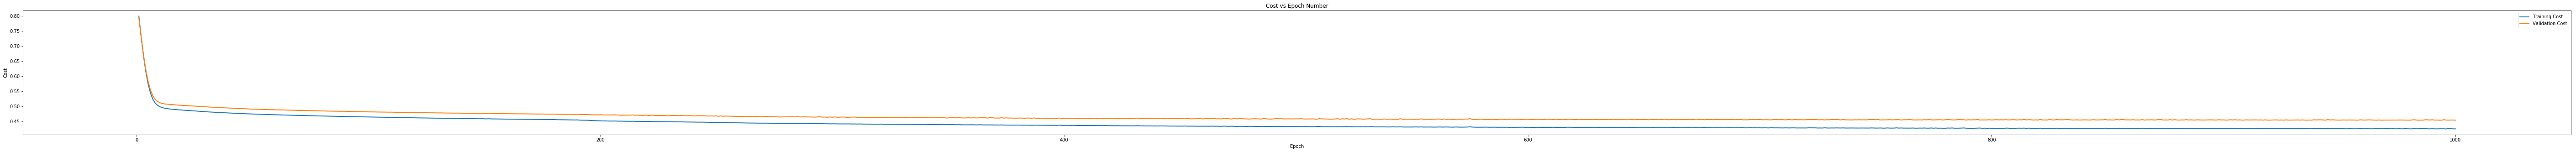

In [8]:
#Note that for a Neural Network of size n. Since we are taking our values from a uniform [0,1)
#distribution that the maximum cost will be 
net = network2.Network([9,100, 12])
data = pickle.load(open('chain_len3.pickle', "rb"))
# train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]
train_data = data[:1000]
test_data = data[1000:1100]
net.SGD(train_data, 1000, 10, 0.001,lmbda = 0, evaluation_data=test_data,eta_update=0)